In [1]:
import os
import cv2
import numpy as np
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam

In [2]:
# Define constants
TRAIN_DIR = "dataset/train"
VALID_DIR = "dataset/valid"
TFLITE_MODEL_NAME = "grape.tflite"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 10

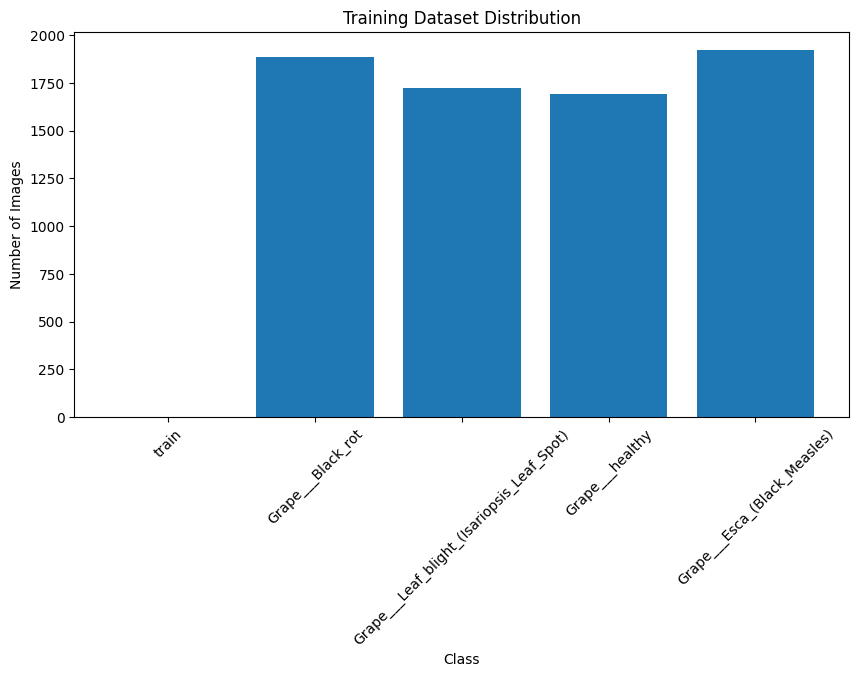

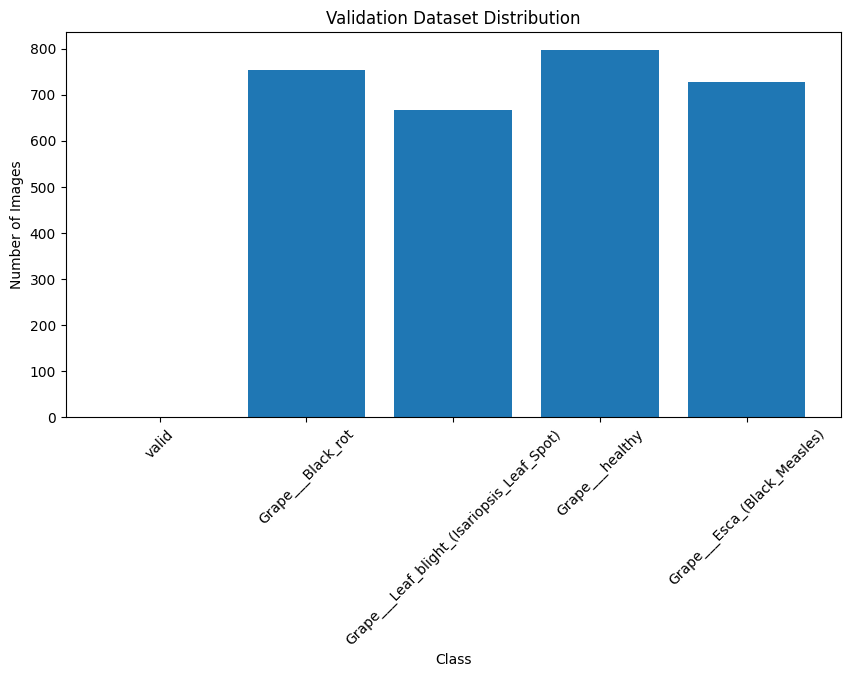

In [3]:
# Function to count and plot the number of images per class
def plot_dataset_distribution(directory, title):
    class_counts = {}
    for root, _, files in os.walk(directory):
        for file in files:
            class_name = os.path.basename(root)
            if class_name not in class_counts:
                class_counts[class_name] = 0
            class_counts[class_name] += 1

    classes = list(class_counts.keys())
    counts = [class_counts[class_name] for class_name in classes]

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

# Plot the training dataset distribution
plot_dataset_distribution(TRAIN_DIR, title="Training Dataset Distribution")

# Plot the validation dataset distribution
plot_dataset_distribution(VALID_DIR, title="Validation Dataset Distribution")

In [4]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Data Augmentation for Validation
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [5]:
# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

# Get the class names (labels)
class_names = list(train_generator.class_indices.keys())

# Display the class names
print("Class Names (Labels):")
for class_name in class_names:
    print(class_name)

Found 7222 images belonging to 4 classes.
Found 2944 images belonging to 4 classes.
Class Names (Labels):
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___healthy


In [6]:
# Get the class labels
class_labels = sorted(train_generator.class_indices.keys())

# Save the class labels to a text file
with open("labels.txt", "w") as file:
    for label in class_labels:
        file.write(label + "\n")


In [7]:
# Create CNN Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(4, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
optimizer = Adam(lr=0.001)  # Experiment with learning rate
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
)

Epoch 1/10
226/226 [==============================] - 263s 1s/step - loss: 0.1427 - accuracy: 0.9556 - val_loss: 30.4906 - val_accuracy: 0.3563
Epoch 2/10
226/226 [==============================] - 244s 1s/step - loss: 0.1033 - accuracy: 0.9754 - val_loss: 14.7551 - val_accuracy: 0.6590
Epoch 3/10
226/226 [==============================] - 257s 1s/step - loss: 0.0908 - accuracy: 0.9778 - val_loss: 14.6520 - val_accuracy: 0.6760
Epoch 4/10
226/226 [==============================] - 257s 1s/step - loss: 0.0404 - accuracy: 0.9896 - val_loss: 1.0311 - val_accuracy: 0.8832
Epoch 5/10
226/226 [==============================] - 245s 1s/step - loss: 0.0372 - accuracy: 0.9922 - val_loss: 2.5089 - val_accuracy: 0.7514
Epoch 6/10
226/226 [==============================] - 254s 1s/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 0.6095 - val_accuracy: 0.9280
Epoch 7/10
226/226 [==============================] - 246s 1s/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.3734 - val_accuracy: 0.9

In [9]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [10]:
# Save the Model
model.save("grape.h5")

/Users/fiq/opt/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Convert to TensorFlow Lite Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite Model
with open(TFLITE_MODEL_NAME, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/cm/xmtvv2v93x5822hn1lr155t40000gn/T/tmpdx77pkqu/assets


INFO:tensorflow:Assets written to: /var/folders/cm/xmtvv2v93x5822hn1lr155t40000gn/T/tmpdx77pkqu/assets
2023-09-14 18:27:18.042859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-14 18:27:18.042877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-14 18:27:18.043017: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/cm/xmtvv2v93x5822hn1lr155t40000gn/T/tmpdx77pkqu
2023-09-14 18:27:18.055446: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-14 18:27:18.055457: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/cm/xmtvv2v93x5822hn1lr155t40000gn/T/tmpdx77pkqu
2023-09-14 18:27:18.090885: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-14 18:27:18.465116: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [13]:
# Load the saved model
loaded_model = tf.keras.models.load_model("grape.h5")

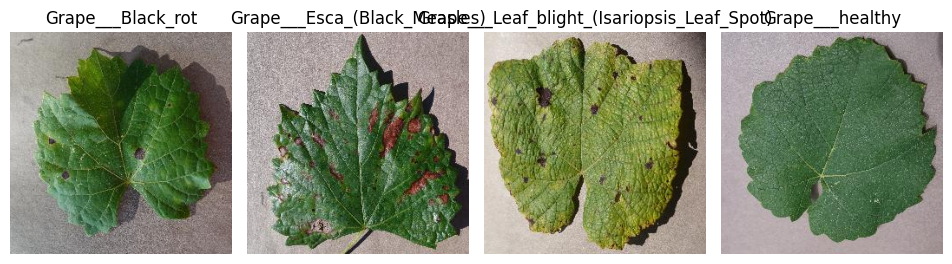

In [14]:
# Visualize dataset classes
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    plt.subplot(2, 5, i + 1)
    img = cv2.imread(os.path.join(TRAIN_DIR, class_name, os.listdir(os.path.join(TRAIN_DIR, class_name))[0]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

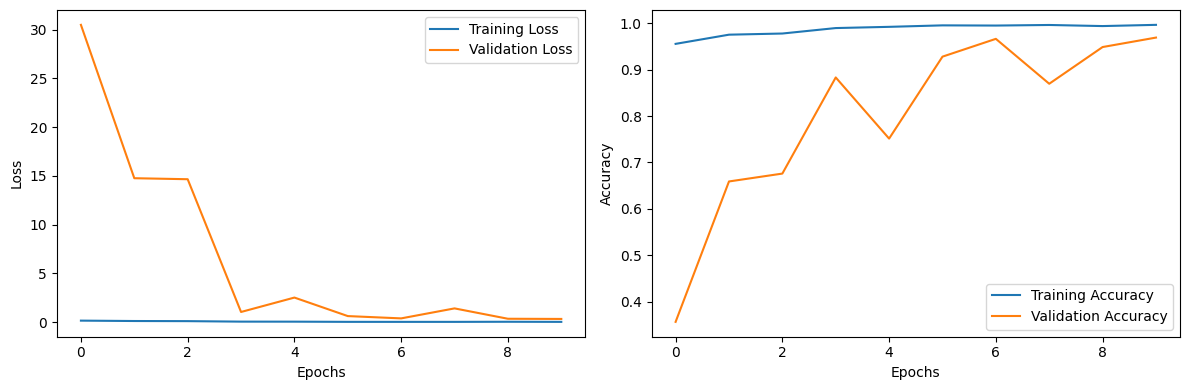

In [15]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

92/92 [==============================] - 16s 176ms/step


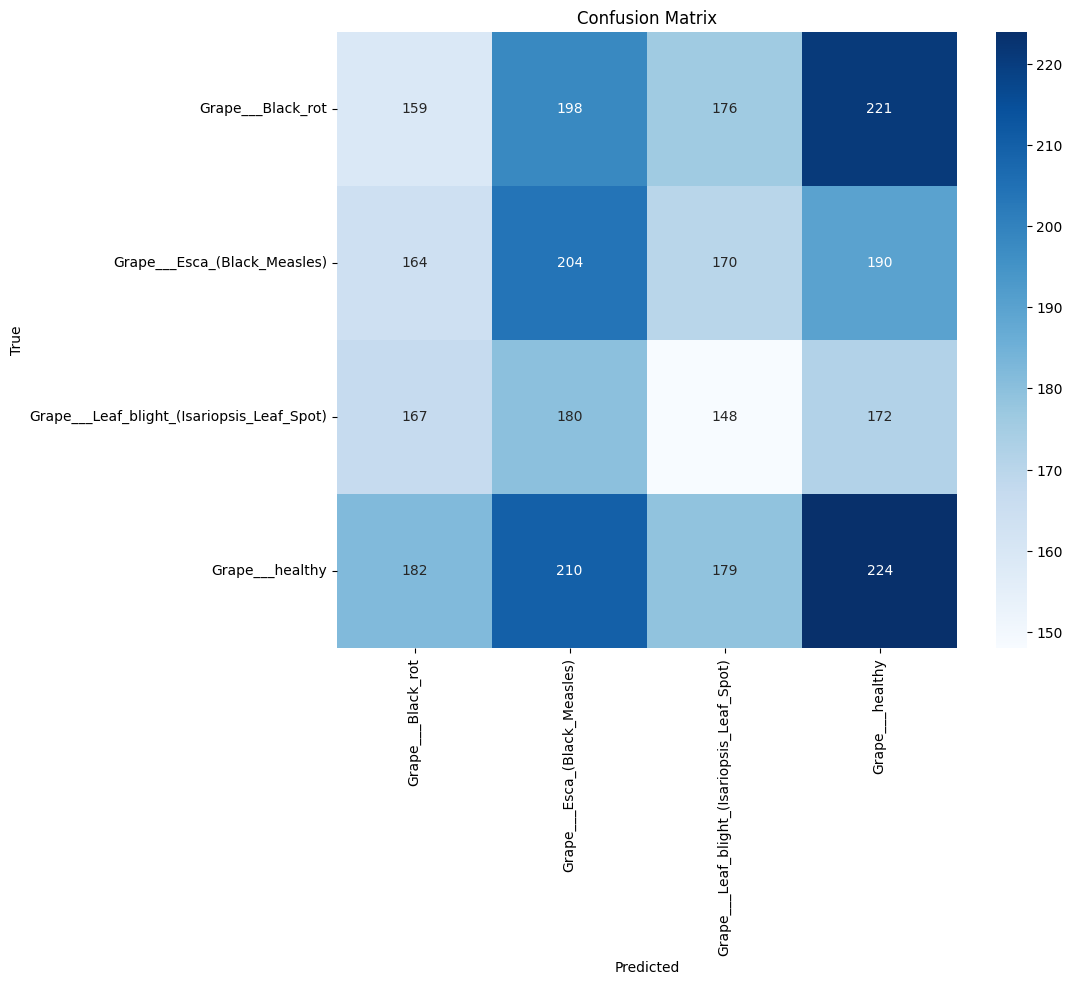

                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.24      0.21      0.22       754
              Grape___Esca_(Black_Measles)       0.26      0.28      0.27       728
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.22      0.22      0.22       667
                           Grape___healthy       0.28      0.28      0.28       795

                                  accuracy                           0.25      2944
                                 macro avg       0.25      0.25      0.25      2944
                              weighted avg       0.25      0.25      0.25      2944



In [16]:
# Generate predictions for the validation dataset using the loaded model
valid_generator.reset()
y_pred = loaded_model.predict(valid_generator, steps=len(valid_generator), verbose=1)
y_true = valid_generator.classes

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names)
print(class_report)

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model('grape.h5')

# Load class labels from class_labels.txt
with open('labels.txt', 'r') as file:
    class_labels = [line.strip() for line in file]

# Load and preprocess the single image
image_path = '/dataset/train/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/de9dc91d-a07b-4b19-bb96-9d5cea2e230b___FAM_L.Blight 4749_flipLR.JPG'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = img_to_array(image)
image = preprocess_input(image)

# Perform inference on the preprocessed image
predictions = model.predict(np.expand_dims(image, axis=0))

# Interpret the model's output (assuming it's a classification model)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class]

# Map the predicted class index to the corresponding label
predicted_label = class_labels[predicted_class]

# Print the predicted label and confidence score
print(f'Predicted label: {predicted_label}')
print(f'Confidence: {confidence:.2f}')